In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import einops

from quant_func import STERound

#aliases
torch.steRound = STERound.apply
torch.gelu = torch.nn.functional.gelu
torch.mul_reduce = torch.prod

In [2]:
# we will use the simplest dataset... ever
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True,transform=transform)

train_size = int(0.9 * len(mnist))  # 54000
test_size = len(mnist) - train_size  # 6000
train_dataset, test_dataset = random_split(mnist, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [3]:
for img,labels in train_loader:
    print(img.shape,labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [22]:
len(train_loader) # total training batches

844

tensor([9, 5, 8, 7, 8])


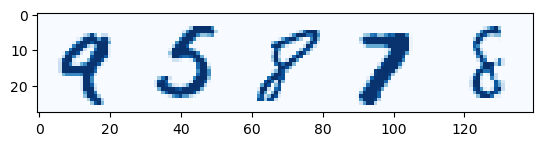

In [4]:
eg,eg_label = img[:5] , labels[:5]
eg = einops.rearrange(eg,"b c h w -> h (b w) c")
plt.imshow(eg,cmap="Blues")
print(eg_label)

In [5]:
class Qconv(torch.nn.Module):
    def  __init__ (self,in_channels,out_channels,kernel_size=3):
        super().__init__()
        # weight tying exp_bits and depth_bits
        # note number  of output  channels  is number of filterkernels  launched
        # we will try to not just compress  but take out entire filter kernels...
        # these asserts them to be pytorch tensors
        in_channels = torch.as_tensor(in_channels)
        out_channels = torch.as_tensor(out_channels)
        kernel_size = torch.as_tensor(kernel_size)

        
        # fan_in is just in_channels
        weight_scale = 1/ torch.sqrt(in_channels*out_channels*out_channels)
        self.weight = torch.ones(out_channels,in_channels,kernel_size,kernel_size)
        self.weight = self.weight.uniform_(-weight_scale,weight_scale)

        # 1 for each kernel (out_channel).. to perform safe broadcasting we have to fill the rest of them with 1
        self.exp_bit = torch.ones(out_channels,1,1,1)*-8.0
        self.depth_bit = torch.ones(out_channels,1,1,1)*4.0

        #register them as trainable parameters
        self.weight = torch.nn.Parameter(self.weight)
        self.exp_bit = torch.nn.Parameter(self.exp_bit)
        self.depth_bit = torch.nn.Parameter(self.depth_bit)
        ...
    
    def size_layer(self):
        """
        given by equation 4 : I*H*W * sum(b(i,l)
        Where O , I , H and W are the output, input, height, and
        width dimensions (so shape) of the weight tensor of layer l respec-
        tively, and b(i,l) is the bit depth of output channel i of layer l.
        """
        prods = torch.as_tensor(self.weight.shape[1:])
        size = torch.mul_reduce(prods) *  torch.relu(torch.sum(self.depth_bit))
        return size

    # @staticmethod
    def _init_weight(self,x):
        x_upscaled = x/torch.exp2(self.exp_bit)
        half = torch.exp2(self.depth_bit -1)
        x_clipped = torch.clip(x_upscaled,-1*half,half-1)
        x_round = torch.steRound(x_clipped)
        return torch.exp2(self.exp_bit) * x_round

    def __call__(self,x):
        # quantize every forward pass
        W = self._init_weight(self.weight)
        # valid padding or should we do same.. paper does not say
        return torch.nn.functional.conv2d(x,W,padding=1)
        
        

torch.Size([32, 28, 28])


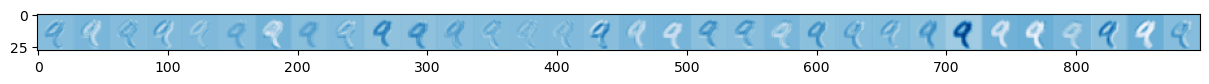

In [8]:
# example convolution (simple unit testing...)
#exemplar forward pass without pooling
input_img = img[0] # 1,28,28
qconv_layer1 = Qconv(1,32)
qconv_layer2 = Qconv(32,48)

out1 = qconv_layer1(input_img)
out2 = qconv_layer2(out1)

print(out1.shape)
out_plot1 = einops.rearrange(out1,"c h w -> h (c w)")
out_plot2 = einops.rearrange(out2,"c h w -> h (c w)")

plt.figure(figsize=(15,8))
plt.imshow(out_plot1.detach(),cmap="Blues")
plt.show()


torch.Size([48, 28, 28])


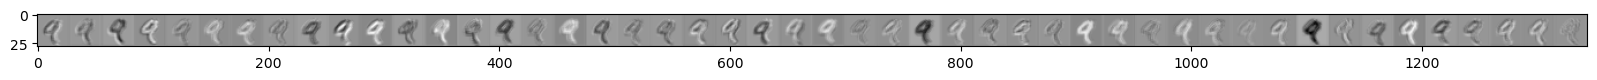

In [9]:
print(out2.shape)
plt.figure(figsize=(20,8))
plt.imshow(out_plot2.detach(),cmap="gray")
plt.show()

In [143]:
# their {exp,depth}_bits... should be 1 per out filter
print(qconv_layer1.exp_bit.shape, qconv_layer1.depth_bit.shape)
print(qconv_layer2.exp_bit.shape, qconv_layer2.depth_bit.shape)

# active parameters (layer size)
print(qconv_layer1.size_layer())
print(qconv_layer2.size_layer())

torch.Size([32, 1, 1, 1]) torch.Size([32, 1, 1, 1])
torch.Size([48, 1, 1, 1]) torch.Size([48, 1, 1, 1])
tensor(1152.)
tensor(55296.)


In [10]:
class QconvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Qconv(1, 32)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = Qconv(32,64)

        # we dont compress linear layers like we did before. (would add *2 number of params)
        self.L1 = torch.nn.Linear(28*28, 1024)
        self.L2 = torch.nn.Linear(1024, 512)
        self.L3 = torch.nn.Linear(512, 10)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv1_out = torch.gelu(conv1_out)
        pool1 = self.pool(conv1_out)

        conv2_out = self.conv2(pool1)
        conv2_out = torch.gelu(conv2_out)
        pool2 = self.pool(conv2_out)
        
        flat = torch.flatten(x, 1) # flatten except batch
        l1 = self.L1(flat)
        l1 = torch.gelu(l1)

        l2 = torch.L2(l1)
        l2 = torch.gelu(l2)
        
        logits = self.L3(l2)
        return logits

In [11]:
qmodel_example = QconvModel()
for p in qmodel_example.named_parameters():
    print(p)

('conv1.weight', Parameter containing:
tensor([[[[-1.1581e-02,  8.6042e-03,  3.2273e-03],
          [-2.3775e-02, -2.8414e-02,  1.1846e-02],
          [ 3.0358e-02,  1.2788e-02, -8.0699e-03]]],


        [[[ 1.5298e-02, -2.6381e-02, -2.4949e-02],
          [ 2.2672e-03, -1.5244e-02,  2.6160e-03],
          [ 1.7426e-03, -2.7168e-02, -2.4139e-02]]],


        [[[-6.0248e-03, -1.1427e-02, -1.3291e-02],
          [-2.7526e-02, -2.3954e-02,  2.2494e-02],
          [-1.2649e-02, -1.7125e-02,  2.9284e-02]]],


        [[[-2.3342e-02,  1.5959e-02,  7.4114e-03],
          [-1.5403e-02, -2.8796e-02, -1.7061e-02],
          [-1.1115e-02,  1.2900e-02,  1.8309e-02]]],


        [[[-2.7425e-02, -7.3793e-03, -2.2739e-02],
          [ 8.2206e-03,  1.6929e-02, -2.4176e-02],
          [-1.4623e-02, -1.9755e-02, -2.9254e-03]]],


        [[[-1.1733e-02,  1.0620e-02, -2.8875e-02],
          [-1.4264e-02, -1.4962e-02,  2.5743e-02],
          [ 2.2270e-02, -1.2856e-02,  3.4299e-03]]],


        [[[-2.2979e

In [21]:
gamma = (1/20) # compression factor
# we need to calculate total number of parameters at initialization (papaer calls it N)
tot_init = torch.sum(torch.tensor([p.numel() for p in qmodel_example.parameters()]))
tot_qparams = torch.sum(torch.tensor([p_weight.numel() for p,p_weight in qmodel_example.named_parameters() if "_bit" in p]))

print(tot_init)
print(tot_qparams) # 32 *2 + 64*2

gamma = gamma/tot_init

tensor(1352682)
tensor(192)


In [ ]:

# @torch.compile
def train(num_epochs:int=100):
    model = QconvModel()
    model.to("cuda")

    from tqdm import tqdm
    pbar_epoch = tqdm(range(epochs))
    optim = torch.optim.AdamW(model.parameters(),weight_decay=1e-3)

    for epoch in pbar_epoch:
        pbar_batch = tqdm(range(len(train_loader)))
        for batch_img, batch_label in pbar_batch:
            
        

    
